# VO2max Prediction Using Treadmill Maximal Exercise Tests and Machine Learning Techniques

In [1]:
#!pip install tsfel


In [2]:
# import packages
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For data visualization
import pandas as pd  # For handling tabular data
import seaborn as sns  # For enhanced visualizations
from scipy import signal  # For signal processing
from collections import Counter  # For counting elements in a collection
from sklearn.utils import indexable, resample  # For data indexing and sampling
from sklearn.utils.validation import _num_samples  # To determine the number of samples in data
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
# For splitting datasets and cross-validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures  # For data scaling and preprocessing
from sklearn.metrics import mean_squared_error  # For regression performance evaluation
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV  # For linear regression models
from sklearn.pipeline import Pipeline  # For building ML pipelines
from sklearn.compose import ColumnTransformer  # For handling multiple feature preprocessing
from math import ceil, floor  # For mathematical computations
from scipy.signal import welch  # For power spectral density estimation
from scipy.stats import linregress, shapiro  # For statistical analysis
from collections import Counter
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR
from xgboost import XGBRegressor

## Loading Dataset

The following code focuses on loading and preprocessing two datasets: subject information and test measurements.

In [3]:
# Loading the subject information dataset
# This dataset contains general information about the participants
subject_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/subject-info.csv')

# basic information
print("Measurement Data Overview:")
display(subject_data.head()) # first rows
print("Initial Dataset Info:")
print(subject_data.info())
print(subject_data.describe()) # statistics

Measurement Data Overview:


Age  Weight  Height  Humidity  Temperature  Sex   ID ID_test
0  10.8    48.8   163.0      39.0         20.7    1  543   543_1
1  11.8    41.0   150.0      41.0         22.3    1   11    11_1
2  12.2    46.0   160.0      37.0         21.5    0  829   829_1
3  13.2    71.0   190.0      49.0         23.8    1  284   284_1
4  13.7    53.8   169.7      40.0         25.3    0  341   341_1

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB
None
              Age      Weight      Height    Humidity  Temperature  \
count  992.000000  992.000000  992.000000  962.000000   962.000000   
mean    28.979133   73.383367  174.913508   48.211435    22.818565   
std     10.076653   12.005361    7.950027    8.560991     2.784066   
min     10.800000   41.000000  150.000000   23.700000    15.000000   
25%     21.100000   66.000000  170.0

In [4]:
# Loading the measurement data, which includes HR, VO2, RR, and other physiological variables
measurement_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/test_measure.csv')

# basic information
print("Measurement Data Overview:")
display(measurement_data.head()) # first rows
print("Measurement Dataset Info:")
print(measurement_data.info())
print(measurement_data.describe()) # statistics

Measurement Data Overview:


time  Speed    HR    VO2   VCO2  RR    VE ID_test  ID
0     0    5.0  63.0  478.0  360.0  27  13.3     2_1   2
1     2    5.0  75.0  401.0  295.0  23  10.3     2_1   2
2     4    5.0  82.0  449.0  319.0  29  12.2     2_1   2
3     7    5.0  87.0  461.0  340.0  28  12.8     2_1   2
4     9    5.0  92.0  574.0  417.0  28  14.6     2_1   2

Measurement Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575087 entries, 0 to 575086
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time     575087 non-null  int64  
 1   Speed    575087 non-null  float64
 2   HR       574106 non-null  float64
 3   VO2      570216 non-null  float64
 4   VCO2     570216 non-null  float64
 5   RR       575087 non-null  int64  
 6   VE       575087 non-null  float64
 7   ID_test  575087 non-null  object 
 8   ID       575087 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 39.5+ MB
None
                time          Speed             HR            VO2  \
count  575087.000000  575087.000000  574106.000000  570216.000000   
mean      628.126172       9.607958     146.940892    2313.617768   
std       325.588844       4.520384      32.206372     978.103888   
min         0.000000       0.000000       0.000000      -5.000000   
25%       375.000000  

## Data Cleaning and Pre-Processing

The feature selection process is based on the Paper: Heart Rate Variability Based Estimation of Maximal Oxygen
Uptake in Athletes Using Supervised Regression Models.

The code implements a pipeline for cleaning the data, which involves handling missing values, removing outliers, and filtering data based on physiological assumptions to ensure quality. 

In [5]:
# check if there are missing values
print("Missing Values per Column:")
print(measurement_data.isnull().sum())

Missing Values per Column:
time          0
Speed         0
HR          981
VO2        4871
VCO2       4871
RR            0
VE            0
ID_test       0
ID            0
dtype: int64


In [6]:
# Defining a data cleaning pipeline
def pipeline_data_cleaning(data):
    """
    Preprocess the measurement data by performing the following steps:
    - Remove rows with missing target variables (HR, VO2).
    - Handle outliers in RR intervals.
    - Ensure HR and VO2 are in-phase for physiological consistency.
    - Filter out improbable HR differences.
    - Retain only data with sufficient duration (≥ 5 minutes).
    - Split the data into exercise and recovery phases.
    
    Parameters:
        data (pd.DataFrame): The raw measurement dataset.
    
    Returns:
        exercise_data (pd.DataFrame): Data from the exercise phase.
        recovery_data (pd.DataFrame): Data from the recovery phase.
    """
    # Remove rows with missing HR or VO2 values
    measurement_data_cleaned = data.dropna(subset=['HR', 'VO2'])
    print(f'Rows removed due to missing HR or VO2: {len(data) - len(measurement_data_cleaned)}')

    # Remove outliers in RR intervals (retain values between 5 and 50 breaths per minute)
    measurement_data_cleaned['RR'] = np.where((measurement_data_cleaned['RR'] < 5) | 
                                              (measurement_data_cleaned['RR'] > 50), 
                                              np.nan, measurement_data_cleaned['RR'])

    # Interpolate missing RR values linearly
    measurement_data_cleaned['RR'] = measurement_data_cleaned['RR'].interpolate(method='linear')

    # Display remaining missing values after interpolation
    print("Remaining Missing Values after Interpolation:")
    print(measurement_data_cleaned.isnull().sum())

    # Remove data points where HR and VO2 changes are not in phase
    delta_hr = np.diff(measurement_data_cleaned['HR'])
    delta_vo2max = np.diff(measurement_data_cleaned['VO2'])
    
    # Adjust dataset indices before applying the in-phase mask
    measurement_data_cleaned = measurement_data_cleaned.iloc[:-1]  # Drop the last row
    in_phase_mask = (delta_hr * delta_vo2max) > 0
    measurement_data_cleaned = measurement_data_cleaned[in_phase_mask]

    # Filter out rows with consecutive HR differences exceeding 30 bpm
    measurement_data_cleaned['HR_diff'] = measurement_data_cleaned['HR'].diff().abs()
    measurement_data_cleaned = measurement_data_cleaned[measurement_data_cleaned['HR_diff'] <= 30]

    # Retain only rows with at least 5 minutes (300 seconds) of data
    measurement_data_cleaned['time'] = measurement_data_cleaned['time'].astype(float)
    measurement_data_cleaned = measurement_data_cleaned[measurement_data_cleaned['time'] >= 300]

    # Print the size of the dataset after cleaning
    print(f'Dataset size after cleaning: {measurement_data_cleaned.shape}')

    # Split the data into exercise and recovery phases
    exercise_data = measurement_data_cleaned[measurement_data_cleaned['Speed'] >= 5]  # Exercise phase
    recovery_data = measurement_data_cleaned[measurement_data_cleaned['Speed'] < 5]  # Recovery phase

    return exercise_data, recovery_data

In [7]:
# Apply the cleaning pipeline to the measurement data
exercise_data, recovery_data = pipeline_data_cleaning(measurement_data)

# Print the sizes of the exercise and recovery datasets
print(f'Exercise data size: {exercise_data.shape}')
print(f'Recovery data size: {recovery_data.shape}')

Rows removed due to missing HR or VO2: 5840
Remaining Missing Values after Interpolation:
time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64
Dataset size after cleaning: (100039, 10)
Exercise data size: (85872, 10)
Recovery data size: (14167, 10)


C:\Users\Eva\AppData\Local\Temp\ipykernel_16360\1900367754.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_data_cleaned['RR'] = np.where((measurement_data_cleaned['RR'] < 5) |
C:\Users\Eva\AppData\Local\Temp\ipykernel_16360\1900367754.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement_data_cleaned['RR'] = measurement_data_cleaned['RR'].interpolate(method='linear')


In [8]:
# Remove all data from test IDs with missing HR or VO2
#difference = pd.merge(merged_data, measurement_data_cleaned, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
#exclude_ids = difference['ID_test'].unique()
#measurement_data_cleaned = measurement_data_cleaned[~measurement_data_cleaned['ID_test'].isin(exclude_ids)]

## Feature Extraction

This section includes detailed descriptions of the code snippets used to process heart rate (HR) and heart rate variability (HRV) data, extract features, normalize them, and perform statistical tests.

#### 1. Poincaré Plot:

This function visualizes the relationship between consecutive RR intervals in a time series using a Poincaré plot. It calculates and displays SD1 (short-term variability) and SD2 (long-term variability).

In [9]:
def poincare_plot(data):
    """
    Generate a Poincaré plot for RR intervals and calculate SD1 and SD2.

    Parameters:
    data (DataFrame): A DataFrame containing an 'RR' column with RR intervals.

    Returns:
    None: Displays the plot and prints SD1, SD2 values.
    """    
    # Sample RR intervals
    rr_intervals = data['RR'].values
    # Calculate consecutive differences for Poincaré plot
    rr_diff1 = rr_intervals[:-1]  # RR interval at time t
    rr_diff2 = rr_intervals[1:]  # RR interval at time t+1

    # Calculate mean of RR intervals
    rr_mean = np.mean(rr_intervals)

    # Calculate SD1 and SD2
    sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
    sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)

    # Line of identity
    identity_line = np.linspace(min(rr_intervals), max(rr_intervals), 100)

    # Create Poincaré plot
    plt.figure(figsize=(8, 8))
    plt.scatter(rr_diff1, rr_diff2, alpha=0.6, label="RR intervals")
    plt.plot(identity_line, identity_line, color="red", linestyle="--", label="Line of Identity")
    plt.xlim(min(rr_intervals), max(rr_intervals)+20)
    plt.ylim(min(rr_intervals), max(rr_intervals)+20)

    # SD1 and SD2 ellipse visualization
    mean_rr = [np.mean(rr_diff1), np.mean(rr_diff2)]
    ellipse_angle = 45
    ellipse_sd1 = plt.Circle(mean_rr, sd1, color="blue", fill=False, label="SD1")
    ellipse_sd2 = plt.Circle(mean_rr, sd2, color="green", fill=False, label="SD2")
    plt.gca().add_patch(ellipse_sd1)
    plt.gca().add_patch(ellipse_sd2)

    # Formatting
    plt.title("Poincaré Plot")
    plt.xlabel("RR Interval (n)")
    plt.ylabel("RR Interval (n+1)")
    plt.legend()
    plt.grid(alpha=0.4)
    plt.axis("equal")
    plt.show()

    # Print SD1 and SD2
    print(f"SD1: {sd1:.2f} ms")
    print(f"SD2: {sd2:.2f} ms")



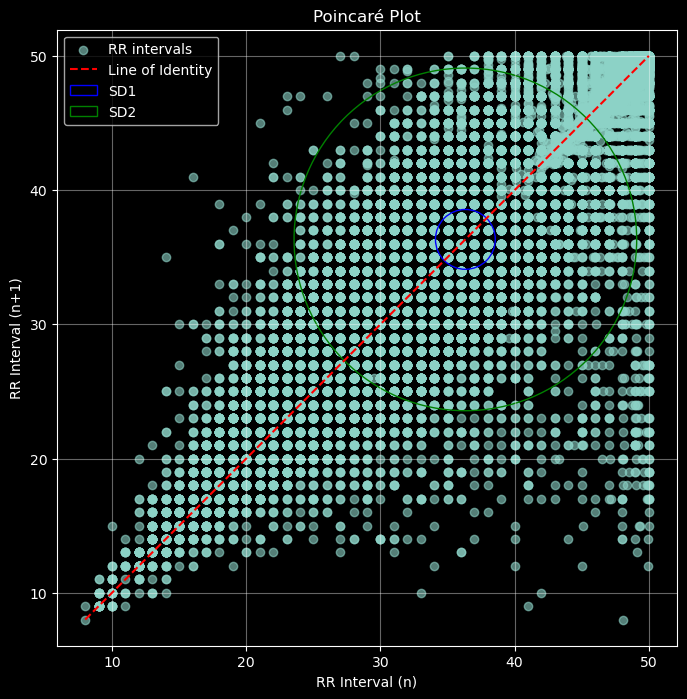

SD1: 2.23 ms
SD2: 12.77 ms


In [10]:
# apply poincare to exercise data

poincare_plot(exercise_data)

Exercise Plot:

Larger Variability (SD1 and SD2):
The points are more widely spread around the line of identity, indicating greater short-term variability (SD1) and long-term variability (SD2).
This is typical during physical activity, as the cardiovascular system adapts to the increased demands of exercise.
The activity of the sympathetic nervous system increases, accelerating the heart rate and increasing the variability in RR intervals.

Higher SD1:
Short-term fluctuations dominate (e.g., from breathing or movement), reflecting the heart's dynamic response to exercise.

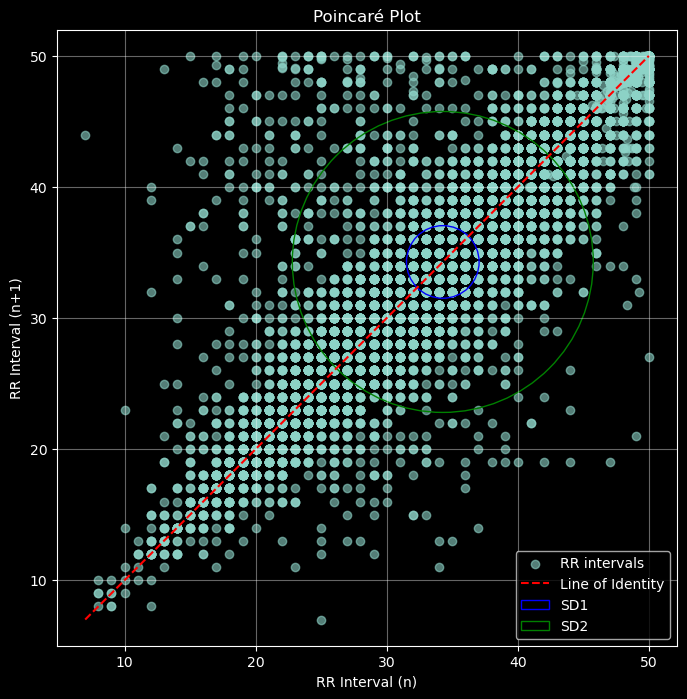

SD1: 2.77 ms
SD2: 11.48 ms


In [11]:
# apply poincare to recovery data

poincare_plot(recovery_data)

Recovery Plot:

Tighter Cluster of Points (Reduced SD1 and SD2):
During recovery, both short-term (SD1) and long-term variability (SD2) decrease as the cardiovascular system transitions back to a resting state.
This reflects activation of the parasympathetic nervous system, which works to slow the heart rate and stabilize RR intervals.

Lower SD1:
Short-term fluctuations diminish as the body's immediate demands are reduced, and the heart rate stabilizes.

Lower SD2:
Long-term variability also decreases, as the heart no longer needs to adjust rapidly to external demands.

#### 2. Calculate Slope for a Feature
This utility calculates the slope of a given feature over time using linear regression.

In [12]:

# Function to calculate slopes over time for a feature

def calculate_slopes(df, feature):
    """
    Calculate the slope of a feature over time using linear regression.

    Parameters:
    df (pd.DataFrame): DataFrame containing the 'time' and feature columns.
    feature (str): The feature column for which the slope is calculated.

    Returns:
    float: Slope of the feature over time. NaN if the input DataFrame is empty.
    """
    if len(df) == 0:  # Handle empty DataFrame
        return np.nan
    else:
        # Use linear regression to calculate the slope
        slope = linregress(df['time'], df[feature]).slope
        return slope
    



#### 3. Compute HR and HRV Features
This function extracts time-domain, frequency-domain, and nonlinear features from a data segment.

In [13]:
 # Function to compute HR & HRV features for a given data segment

def compute_hr_features(segment: pd.DataFrame) -> dict:
    """
    Calculate heart rate variability (HRV) features and additional metrics from a data segment.

    Parameters:
    segment (pd.DataFrame): A DataFrame containing the segment data.

    Returns:
    dict: A dictionary of computed features.
    """

    hr = segment['HR'].values
    time = segment['time'].values
    rr_intervals = segment['RR'].values 

    # Time-Domain-Features
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # RMSSD: Root Mean Square of Successive Differences
    pnn20 = np.mean(np.abs(np.diff(rr_intervals)) > 0.5) * 100  # % of differences > 20 ms
    pnn50 = np.mean(np.abs(np.diff(rr_intervals)) > 1.25) * 100  # % of differences > 50 ms
    nni20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.5)  # Count of differences > 20 ms
    nni50 = np.sum(np.abs(np.diff(rr_intervals)) > 1.25)  # Count of differences > 50 ms
    nni_range = np.max(rr_intervals) - np.min(rr_intervals)  # Range of RR intervals
    
    # Frequency-Domain-Features
    fs = 4  # Sampling frequency in Hz (adjust based on your data)
    f, pxx = welch(rr_intervals, fs, nperseg=len(rr_intervals))  # Welch's power spectral density
    vlf_power = np.trapz(pxx[(f >= 0.003) & (f < 0.04)], f[(f >= 0.003) & (f < 0.04)])  # VLF band
    lf_power = np.trapz(pxx[(f >= 0.04) & (f < 0.15)], f[(f >= 0.04) & (f < 0.15)])  # LF band
    hf_power = np.trapz(pxx[(f >= 0.15) & (f < 0.4)], f[(f >= 0.15) & (f < 0.4)])  # HF band
    lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)  # LF normalized power

    # Nonlinear Features (Poincare Plot, DFA)
    sd1 = np.sqrt(0.5) * np.std(rr_intervals[1:] - rr_intervals[:-1])  # Short-term variability
    sd2 = np.sqrt(2 * np.std(rr_intervals[:-1]) ** 2 - sd1 ** 2)  # Long-term variability
    dfa_a1 = np.std(rr_intervals[:len(rr_intervals)//2]) / np.std(rr_intervals)  # Placeholder for DFA Alpha-1
    
    # Slope-Based Features
    slope_nni = np.polyfit(time, rr_intervals, 1)[0]  # Slope of NN intervals over time

    # Additional Features
    max_hr = max(hr)  # Max HR in the segment
    min_hr = min(hr)  # Min HR in the segment
    vo2_max = segment['VO2'].max()  # Max VO2 in the segment
    
    # Slopes for Poincare Plot Features
    # slope_sd1 = np.polyfit(time, [sd1] * len(time), 1)[0]
    # slope_sd2 = np.polyfit(time, [sd2] * len(time), 1)[0]

    # Time-based features
    max_speed = segment['Speed'].max()
    slope_sp25 = calculate_slopes(segment[segment['Speed'] <= max_speed * 0.25], 'HR')
    slope_sp50 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.5) & (segment['Speed'] > max_speed * 0.25)], 'HR')
    slope_sp75 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.75) & (segment['Speed'] > max_speed * 0.5)], 'HR')
    slope_sp100 = calculate_slopes(segment[(segment['Speed'] > max_speed * 0.75)], 'HR')
    rt25 = segment.loc[segment['time'] <= segment['time'].max() * 0.25, 'HR'].corr(segment['time'])
    rt50 = segment.loc[(segment['time'] >= segment['time'].max() * 0.25) & (segment['time'] < segment['time'].max() * 0.5), 'HR'].corr(segment['time'])
    rt75 = segment.loc[(segment['time'] >= segment['time'].max() * 0.5) & (segment['time'] < segment['time'].max() * 0.75), 'HR'].corr(segment['time'])
    rsp75 = segment.loc[segment['Speed'] <= max_speed * 0.75, 'HR'].corr(segment['Speed'])
    rsp25 = segment.loc[segment['Speed'] <= max_speed * 0.25, 'HR'].corr(segment['Speed'])
    time_sp25 = segment[segment['Speed'] >= max_speed * 0.25]['time'].min()
    time_hr25 = segment[segment['HR'] >= max_hr * 0.25]['time'].min()
    time_hr50 = segment[segment['HR'] >= max_hr * 0.5]['time'].min()
    time_hr75 = segment[segment['HR'] >= max_hr * 0.75]['time'].min()
    duration_hr60 = len(segment[(segment['HR'] >= max_hr * 0.5) & (segment['HR'] < max_hr * 0.6)]) * (segment['time'].diff().mean())
    duration_hr70 = len(segment[(segment['HR'] >= max_hr * 0.6) & (segment['HR'] < max_hr * 0.7)]) * (segment['time'].diff().mean())
    duration_hr80 = len(segment[(segment['HR'] >= max_hr * 0.7) & (segment['HR'] < max_hr * 0.8)]) * (segment['time'].diff().mean())
    duration_hr90 = len(segment[(segment['HR'] >= max_hr * 0.8) & (segment['HR'] < max_hr * 0.9)]) * (segment['time'].diff().mean())
    duration_hr100 = len(segment[(segment['HR'] >= max_hr * 0.9) & (segment['HR'] <= max_hr)]) * (segment['time'].diff().mean())

    
    # Feature Dictionary
    Features = {'RMSSD': rmssd,
        'PNN20': pnn20,
        'PNN50': pnn50,
        'NNI20': nni20,
        'NNI50': nni50,
        'NNI_Range': nni_range,
        'VLF_Power': vlf_power,
        'LF_Power': lf_power,
        'HF_Power': hf_power,
        'LF_Nu_Power': lf_nu_power,
        'SD1': sd1,
        'SD2': sd2,
        'DFA_A1': dfa_a1,
        'Slope_NNI': slope_nni,
        'Slope_Speed25': slope_sp25,
        'Slope_Speed50': slope_sp50,
        'Slope_Speed75': slope_sp75,
        'Slope_Speed100': slope_sp100,
        'RT25': rt25,
        'RT50': rt50,
        'RT75': rt75,
        'RSP75': rsp75,
        'RSP25': rsp25,
        'Time_SP25': time_sp25,
        'Time_HR25': time_hr25,
        'Time_HR50': time_hr50,
        'Time_HR75': time_hr75,
        'DurationHR60': duration_hr60,
        'DurationHR70': duration_hr70,
        'DurationHR80': duration_hr80,
        'DurationHR90': duration_hr90,
        'DurationHR100': duration_hr100,
        'VO2max': segment['VO2'].max(),
    }
    
    return Features

In [14]:
# Function to calculate features for each segment
def calculate_features_per_segment(df, test_column):
    """
    Calculate features for each segment grouped by the specified column.

    Parameters:
    df (pd.DataFrame): The input data.
    test_column (str): The column to group by (e.g., test IDs).

    Returns:
    pd.DataFrame: DataFrame of computed features for each segment.
    """
    all_features = []  # List to store features for all segments

    for test_id, df_segment in df.groupby(test_column):  # Group by the test column
        features = compute_hr_features(df_segment)  # Compute features for the segment
        features[test_column] = test_id  # Add the test ID to the features
        all_features.append(features)  # Append the features

    return pd.DataFrame(all_features)  # Return all features as a DataFrame

In [15]:
# just for testing the feature calculation
# for test_id, df_segment in merged_data_cleaned.groupby('ID_test'):
#     #print(test_id)
#     if test_id == '3_1':
#         test_segment = merged_data_cleaned[merged_data_cleaned['ID_test'] == test_id]
#         break
# compute_hr_features(test_segment)

#### 4. Feature Normalization
Normalize numerical features to have a mean of 0 and a standard deviation of 1.

In [16]:
# Function to normalize numerical features in a DataFrame
def normalize_features(dataframe):
    """
    Normalize numerical features in a DataFrame using StandardScaler.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with normalized numerical features.
    """
    # Identify numerical columns (excluding target variables or IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Initialize StandardScaler (scales data to mean=0, std=1)
    scaler = StandardScaler()

    # Fit and transform numerical features
    normalized_data = scaler.fit_transform(dataframe[numerical_features])

    # Convert normalized data back to a DataFrame for readability
    normalized_df = pd.DataFrame(normalized_data, columns=numerical_features)

    # Copy the original DataFrame and replace numerical columns with normalized values
    normalized_features = dataframe.copy()
    normalized_features[numerical_features] = normalized_df

    return normalized_features



In [17]:
# pipeline for feature extraction and normalization

def pipeline_feature_extraction(data, subject_data):
    """
    Extract and normalize features from the data pipeline.

    Parameters:
    data (DataFrame): Input data.
    subject_data (DataFrame): Metadata.

    Returns:
    DataFrame: Normalized feature data.
    """
    additional_features = calculate_features_per_segment(data, 'ID_test')#ID_test_y')
    
    #new_features['ID_test'] = new_features['ID_test_y']
    merged_data = pd.merge(subject_data, additional_features, on='ID_test', how='inner')
    
    # delete ID columns as they are not needed for the model
    merged_data = merged_data.drop(columns=['ID_test', 'ID'])
    
    normalized_features = normalize_features(merged_data)
    
    return normalized_features

normalized_features_exercise = pipeline_feature_extraction(exercise_data, subject_data)
normalized_features_recovery = pipeline_feature_extraction(recovery_data, subject_data)

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\

In [18]:
normalized_features_exercise.columns

Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'RMSSD',
       'PNN20', 'PNN50', 'NNI20', 'NNI50', 'NNI_Range', 'VLF_Power',
       'LF_Power', 'HF_Power', 'LF_Nu_Power', 'SD1', 'SD2', 'DFA_A1',
       'Slope_NNI', 'Slope_Speed25', 'Slope_Speed50', 'Slope_Speed75',
       'Slope_Speed100', 'RT25', 'RT50', 'RT75', 'RSP75', 'RSP25', 'Time_SP25',
       'Time_HR25', 'Time_HR50', 'Time_HR75', 'DurationHR60', 'DurationHR70',
       'DurationHR80', 'DurationHR90', 'DurationHR100', 'VO2max'],
      dtype='object')

In [19]:
# shapes of dataframes
print(f'Exercise data size: {normalized_features_exercise.shape}')
print(f'Recovery data size: {normalized_features_recovery.shape}')

Exercise data size: (981, 39)
Recovery data size: (317, 39)


#### 5. Shapiro-Wilk Test
This function tests the normality of each feature using the Shapiro-Wilk test.

In [20]:
# Function to perform Shapiro-Wilk test for normality on each numerical feature
def shapiro_wilk_test(dataframe):
    """
    Perform the Shapiro-Wilk test for normality on all numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    tuple: A DataFrame with Shapiro-Wilk test results (statistic and p-value) 
           and another DataFrame identifying non-normally distributed features.
    """
    # Identify numerical columns (excluding target variables or IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Dictionary to store Shapiro-Wilk test results
    shapiro_results = {}

    for column in numerical_features:
        # Perform Shapiro-Wilk test for the column
        stat, p = shapiro(dataframe[column])
        shapiro_results[column] = {'Statistic': stat, 'p-value': p}

    # Convert results dictionary to a DataFrame
    shapiro_results_df = pd.DataFrame(shapiro_results).T
    shapiro_results_df.columns = ['Shapiro Statistic', 'p-value']

    # Identify features that are not normally distributed (p-value <= 0.05)
    non_normal_features = shapiro_results_df[shapiro_results_df['p-value'] <= 0.05]

    return shapiro_results_df, non_normal_features



In [21]:
# Run Shapiro-Wilk test and display results for exercise and recovery data
print("Shapiro-Wilk Test Results for Exercise Data:")
shapiro_results_exercise, non_normal_features_exercise = shapiro_wilk_test(normalized_features_exercise)
print(shapiro_results_exercise)  # Uncomment to display the full results for all features

print("Shapiro-Wilk Test Results for Recovery Data:")
shapiro_results_recovery, non_normal_features_recovery = shapiro_wilk_test(normalized_features_recovery)
print(shapiro_results_recovery)  # Uncomment to display the full results for all features

# Display features that are not normally distributed
print("\nExercise Features that are NOT Normally Distributed:")
print(non_normal_features_exercise)

print("\nRecovery Features that are NOT Normally Distributed:")
print(non_normal_features_recovery)

Shapiro-Wilk Test Results for Exercise Data:
                Shapiro Statistic       p-value
Age                      0.960223  1.092042e-15
Weight                   0.981725  9.514245e-10
Height                   0.996589  3.198692e-02
Humidity                      NaN           NaN
Temperature                   NaN           NaN
Sex                      0.423068  2.996888e-48
RMSSD                    0.964771  1.174175e-14
PNN20                    0.962115  2.863421e-15
PNN50                    0.997541  1.486450e-01
NNI_Range                0.991673  2.444314e-05
VLF_Power                0.020442  6.173173e-57
LF_Power                 0.799519  3.997152e-33
HF_Power                 0.743751  2.254826e-36
LF_Nu_Power                   NaN           NaN
SD1                      0.965043  1.362248e-14
SD2                      0.992437  6.603047e-05
DFA_A1                   0.961254  1.839111e-15
Slope_NNI                0.959092  6.231946e-16
Slope_Speed25                 NaN          

c:\Users\Eva\Documents\Uni\Erasmus\AAEB\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Key Insights from Exercise Data:

Normally Distributed Variables (p-value ≥ 0.05):
PNN50: Indicates some of the short-term HRV features could be normally distributed.
VO2max: Indicates a normal distribution for the maximum oxygen uptake data.

Non-Normally Distributed Variables (p-value < 0.05):
Many HRV-related features like RMSSD, SD1, SD2, PNN20, LF Power, HF Power, and slope metrics do not follow a normal distribution during exercise. This reflects the physiological variability due to heightened autonomic control during exercise.
Demographic variables such as Age, Weight, Sex are also non-normal, likely due to sample-specific characteristics.

Strongly Non-Normal Variables (p-value near 0):
Metrics like VLF Power (p ≈ 0), Time_HR25, and other time-based heart rate variables show extreme deviation from normality. These may require transformations (e.g., logarithmic) or non-parametric analysis.

Key Insights from Recovery Data:

Normally Distributed Variables (p-value ≥ 0.05):
Height, Time_HR75, and NNI_Range show evidence of being normally distributed.

Non-Normally Distributed Variables (p-value < 0.05):
Key HRV features such as RMSSD, PNN20, NNI20, SD1, and HF Power are not normally distributed, even during recovery. This suggests residual variability in autonomic regulation post-exercise.
Most time-based variables and VO2max also deviate from normality.

Strongly Non-Normal Variables:
Features like LF Power, HF Power, and Time_SP25 show extreme deviations from normality during recovery as well, reflecting irregular recovery dynamics.

A lot features are not normally distributed which is we choose Feature Selection Methods that do not assume the data to be normally distributed (Mutual Information, Spearson Coefficient).

## Correlation-based, Mutual-information-based and greedy forward and backward Feature Selection

This section is responsible for identifying highly correlated features in the dataset, selecting the most important features and deleting redundant ones.

In [22]:
# Identify and visualize highly correlated features
def correlated_features(dataframe, threshold=0.7, plot_result=True):
    """
    Identifies pairs of highly correlated features based on the given threshold and visualizes the correlation matrix.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        threshold (float): The correlation coefficient threshold to identify highly correlated features. Default is 0.7.

    Returns:
        pd.DataFrame: A dataframe containing pairs of highly correlated features.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr()
    
    if plot_result == True:
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='seismic', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

    # Find highly correlated feature pairs (off-diagonal elements > threshold)
    highly_correlated_pairs = correlation_matrix.where(
        (correlation_matrix.abs() > threshold) & (np.eye(correlation_matrix.shape[0]) == 0)
    ).stack()
    highly_correlated_pairs = pd.DataFrame(highly_correlated_pairs).T

    if not highly_correlated_pairs.empty:
        print("\nHighly Correlated Feature Pairs:")
        print(highly_correlated_pairs)

    return highly_correlated_pairs


In [23]:

# 3. Korrelation mit dem Zielwert
#correlation_with_target = normalized_features.corr()[target_column].drop(target_column)

# Features mit starker Korrelation zum Zielwert
#strongly_correlated_features = correlation_with_target[correlation_with_target.abs() > 0.5]
#print("Features mit starker Korrelation zum Zielwert:")
#print(strongly_correlated_features)

# 5. Mutual Information für nicht-lineare Zusammenhänge
#mi_scores = mutual_info_regression(features, target)
#mi_scores_df = pd.Series(mi_scores, index=features.columns).sort_values(ascending=False)
#print("\nMutual Information Scores:")
#print(mi_scores_df)

# 6. Scatterplots für interessante Features
#top_features = mi_scores_df.head(5).index  # Die 5 wichtigsten Features
#for feature in top_features:
 #   plt.figure(figsize=(6, 4))
  #  sns.scatterplot(x=features[feature], y=target)
   # plt.title(f"Zusammenhang zwischen {feature} und Zielwert")
    #plt.xlabel(feature)
    #plt.ylabel(target_column)
    #plt.show()


In [24]:
# Remove highly correlated features
def remove_correlated_features(dataframe, highly_correlated_pairs):
    """
    Removes one feature from each pair of highly correlated features.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        highly_correlated_pairs (pd.DataFrame): Dataframe containing pairs of highly correlated features.

    Returns:
        pd.DataFrame: The dataframe with highly correlated features removed.
    """
    # Flatten pairs to count occurrences of each feature
    flat_features = [item for pair in highly_correlated_pairs for item in pair]
    feature_counts = Counter(flat_features)

    # Initialize sets to keep track of features to keep and drop
    features_to_keep = set()
    features_to_drop = set()

    # Process each pair to decide which feature to drop
    for feature1, feature2 in highly_correlated_pairs:
        # If neither feature is already marked for keeping, drop the less frequent one
        if feature1 not in features_to_keep and feature2 not in features_to_keep:
            if feature_counts[feature1] >= feature_counts[feature2]:
                features_to_keep.add(feature1)
                features_to_drop.add(feature2)
            else:
                features_to_keep.add(feature2)
                features_to_drop.add(feature1)
        # If one is already kept, drop the other
        elif feature1 in features_to_keep:
            features_to_drop.add(feature2)
        elif feature2 in features_to_keep:
            features_to_drop.add(feature1)

    # Get the final list of features to keep
    final_features = set(flat_features) - features_to_drop
    print(f"Features to keep: {sorted(final_features)}")
    print(f"Features to drop: {sorted(features_to_drop)}")
    reduced_data = dataframe.drop(columns=features_to_drop)
    return reduced_data

In [25]:
# Remove features with more than 50% missing values
def remove_nan_features(dataframe, threshold=0.5):
    """
    Removes features with a high percentage of missing values.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        threshold (float): The threshold for the fraction of NaN values. Features with NaN percentage > threshold will be removed.

    Returns:
        pd.DataFrame: The dataframe with features having high NaN percentages removed.
    """
    nan_counts = dataframe.isnull().mean()
    features_to_remove = nan_counts[nan_counts > threshold].index
    print(f"Features to remove with more than {threshold * 100}% NaN values: {features_to_remove}")
    reduced_data = dataframe.drop(columns=features_to_remove)
    return reduced_data

#### Mutual Information
This function selects features based on their Mutual Information (MI) scores, which quantify the dependence between features and the target variable. Features with an MI score greater than the threshold are selected for the final model.

In [26]:
# Feature Selection using Mutual Information

def mutual_information_FS(dataframe, target_column, threshold=0.0):
    """
    Selects features based on their Mutual Information scores with the target variable.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        threshold (float): Minimum Mutual Information score for a feature to be selected. Default is 0.0.

    Returns:
        pd.DataFrame: A dataframe containing Mutual Information scores for all features.
        pd.DataFrame: A dataframe containing only the selected features.
    """
    # Separate features and target
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    
    # Ignore features with NaN values
    X = X.dropna(axis=1)

    # Calculate Mutual Information scores
    mi_scores = mutual_info_regression(X, y)

    # Create a DataFrame for feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mi_scores
    }).sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

    # Select features based on threshold
    selected_features = feature_scores[feature_scores['Mutual_Information'] > threshold]['Feature']
    print(f"Selected Features (MI > {threshold}): {selected_features.to_list()}")

    # Create a new dataframe with selected features and the target
    selected_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return feature_scores, selected_dataframe

#### Spearman Correlation
Spearman correlation measures the monotonic relationship between two variables. This function removes features that have a low Spearman correlation with the target variable, based on the specified threshold.

In [27]:
# Feature Selection with Spearman Coefficient

def clean_dataframe_by_spearman(dataframe, target_column, threshold=0.1):
    """
    Cleans a dataframe by removing features with Spearman correlation below a given threshold.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
        threshold (float): The minimum absolute Spearman correlation for a feature to be retained.

    Returns:
        pd.DataFrame: A cleaned dataframe with only features strongly correlated with the target.
        pd.DataFrame: A summary of Spearman correlation coefficients for all features.
    """
    # Initialize a dictionary to store Spearman correlation coefficients
    spearman_results = {}

    # Iterate over all columns except the target column
    for column in dataframe.columns:
        if column != target_column:
            # Compute Spearman correlation and p-value
            correlation, _ = spearmanr(dataframe[column], dataframe[target_column])
            spearman_results[column] = correlation

    # Convert results to a DataFrame for analysis
    spearman_df = pd.DataFrame({
        'Feature': spearman_results.keys(),
        'Spearman_Coefficient': spearman_results.values()
    })

    # Filter features based on the threshold
    selected_features = spearman_df[
        spearman_df['Spearman_Coefficient'].abs() >= threshold
    ]['Feature']

    # Retain only the selected features and the target column
    cleaned_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return cleaned_dataframe, spearman_df.sort_values(by='Spearman_Coefficient', ascending=False).reset_index(drop=True)

In [28]:
# Feature Selection pipeline

def feature_selection_pipeline(dataframe, target_column='VO2max', corr_threshold = 0.9, nan_threshold=0.5, mi_threshold=0.0, spearman_threshold=0.1, correlation_fs = True, nan_fs = True, mi_fs = True, spearman_fs = True):
    """
    A pipeline that combines multiple feature selection methods:
    - Remove highly correlated features.
    - Remove features with more than `nan_threshold` missing values.
    - Apply Mutual Information-based feature selection.
    - Apply Spearman correlation-based feature selection.
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        corr_threshold (float): Threshold for removing highly correlated features.
        nan_threshold (float): Fraction of missing values above which a feature is removed.
        mi_threshold (float): Minimum Mutual Information score for a feature to be selected.
        spearman_threshold (float): Minimum absolute Spearman correlation for a feature to be retained.
    
    Returns:
        pd.DataFrame: A dataframe with selected features after all steps.
        pd.DataFrame: A summary of feature selection results (Mutual Information and Spearman).
    """
    if nan_fs == True:
        # # Option 2: Remove features with more than 50% missing values
        # Remove features with more than `nan_threshold` missing values
        dataframe = remove_nan_features(dataframe, nan_threshold)
        
    if correlation_fs == True:
        # # Option 1: Remove highly correlated features
        # Identify highly correlated features for exercise and recovery datasets
        highly_correlated_pairs_exercise = correlated_features(dataframe, threshold = corr_threshold, plot_result = True)
        dataframe = remove_correlated_features(dataframe, highly_correlated_pairs_exercise)
        
    if mi_fs == True:
        # # Option 3: Remove features with more than 50% missing values
        # Apply Mutual Information feature selection
        mi_scores, dataframe = mutual_information_FS(dataframe, target_column, mi_threshold)
        print(mi_scores)
    
    if spearman_fs == True:
        # # Option 4: Apply Spearman correlation
        # Apply Spearman correlation-based feature selection
        dataframe, spearman_df = clean_dataframe_by_spearman(dataframe, target_column, spearman_threshold)
        print(spearman_df)
    
    
    return dataframe
    

Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'RT25', 'RSP25'], dtype='object')


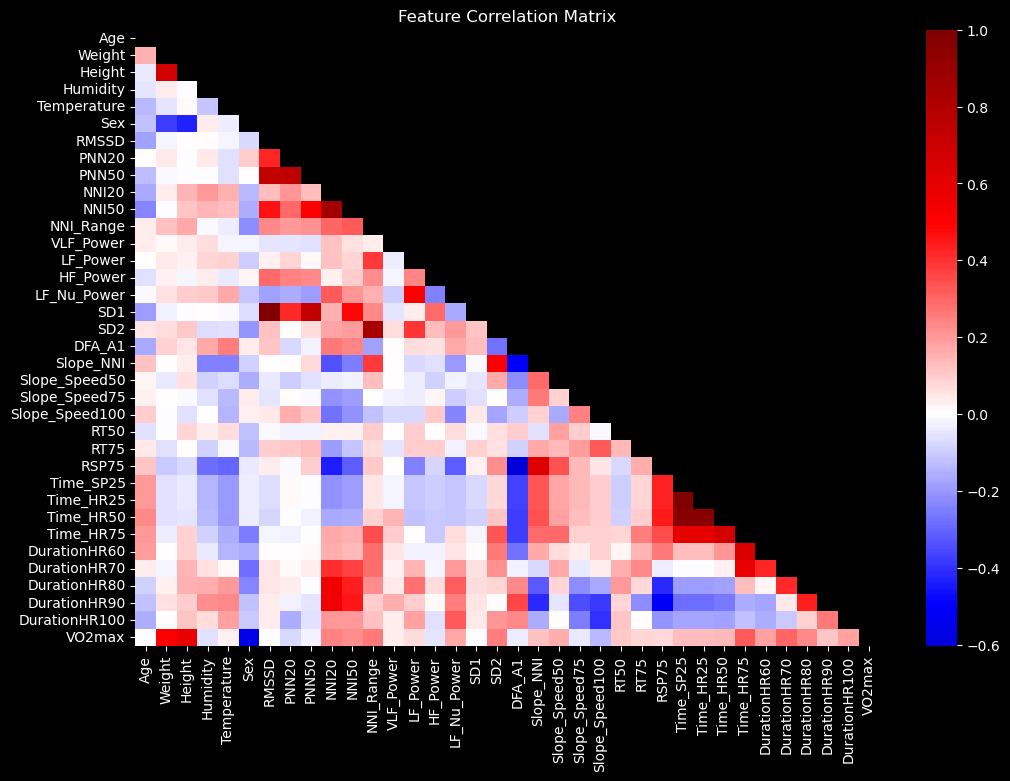


Highly Correlated Feature Pairs:
      RMSSD              PNN20     PNN50                        NNI20  \
      PNN50       SD1    PNN50     RMSSD    PNN20       SD1     NNI50   
0  0.731202  0.998926  0.75504  0.731202  0.75504  0.725775  0.859075   

      NNI50 NNI_Range       SD1                 SD2 Time_SP25            \
      NNI20       SD2     RMSSD     PNN50 NNI_Range Time_HR25 Time_HR50   
0  0.859075  0.839849  0.998926  0.725775  0.839849       1.0  0.957524   

  Time_HR25           Time_HR50            
  Time_SP25 Time_HR50 Time_SP25 Time_HR25  
0       1.0  0.957524  0.957524  0.957524  
Features to keep: ['NNI20', 'NNI_Range', 'PNN50', 'Time_SP25']
Features to drop: ['NNI50', 'PNN20', 'RMSSD', 'SD1', 'SD2', 'Time_HR25', 'Time_HR50']
Selected Features (MI > 0.01): ['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'DurationHR60', 'DurationHR70', 'DurationHR80', 'PNN50', 'NNI_Range', 'Slope_Speed100', 'DurationHR100', 'Age', 'Slope_NNI', 'LF_Power']
           Feature  M

Index(['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'DurationHR60',
       'DurationHR70', 'DurationHR80', 'PNN50', 'NNI_Range', 'Slope_Speed100',
       'DurationHR100', 'Age', 'Slope_NNI', 'LF_Power', 'VO2max'],
      dtype='object')

In [29]:
# feature selection for exercise data

final_data_exercise = feature_selection_pipeline(
    normalized_features_exercise, target_column='VO2max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.01, 
    spearman_threshold=0.1,
    nan_fs = True, correlation_fs = True, mi_fs = True, spearman_fs = False
)
final_data_exercise.columns

At first, RT25, SlopeSpeed25 and RSP25 are filtered out because over 50% of their values are NaN. To avoid multicollinearity, some features are dropped that are highly correlated. NNI50 is dropped because of their high correlation with NNI20. RMSSD and PNN20 show a high correlation with PNN50. TimeHR25 and TimeHR50 are highly correlated with TimeSP25 and therefore dropped. And lastly, SD1 and SD2 are correlated to NNI_range and therefore dropped.

With Mutual Information Calculations the columns ['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'ID', 'DurationHR70', 'DurationHR60', 'DurationHR80', 'PNN50', 'NNI_Range', 'Slope_Speed100', 'DurationHR100', 'Age', 'Time_SP25', 'LF_Power', 'Slope_NNI'] were selected as they are correlated to the target column. 
['ID_test', 'HF_Power', 'RSP75', 'Temperature', 'DurationHR90', 'Slope_Speed75', 'RT75', 'Slope_Speed50', 'Humidity', 'DFA_A1', 'RT50', 'VLF_Power', 'LF_Nu_Power'] were dropped.

Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'Slope_Speed50', 'Slope_Speed75', 'RT25', 'RT50',
       'RT75', 'RSP75', 'RSP25'],
      dtype='object')


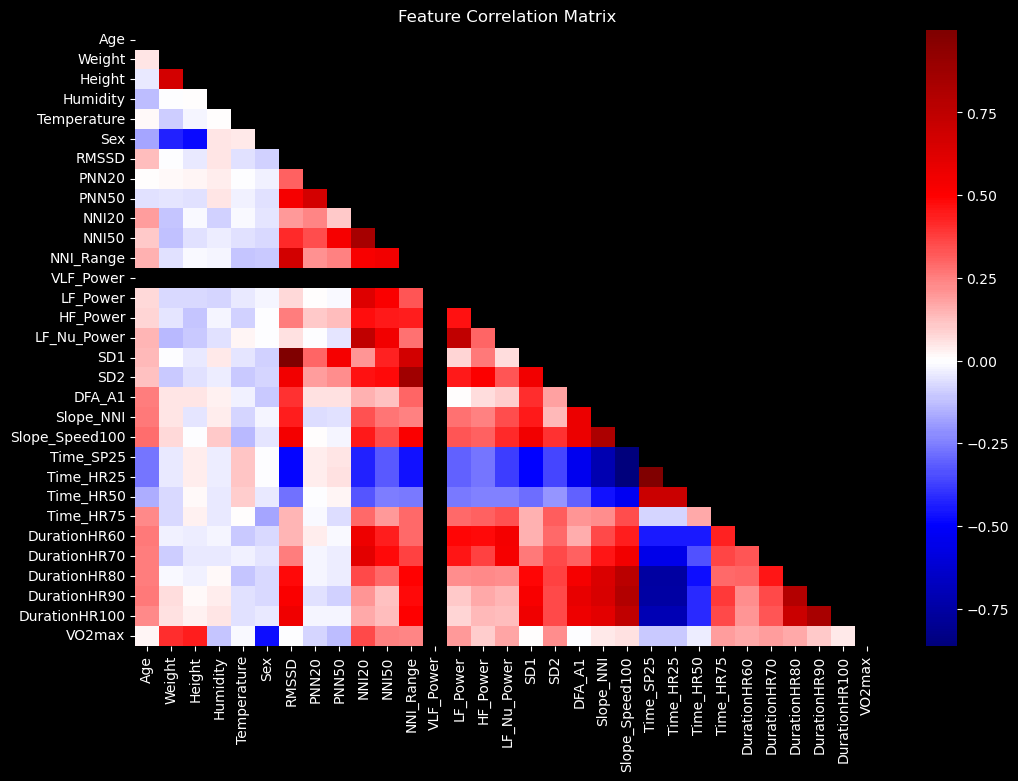


Highly Correlated Feature Pairs:
     RMSSD     NNI20                 NNI50 NNI_Range    LF_Power LF_Nu_Power  \
       SD1     NNI50 LF_Nu_Power     NNI20       SD2 LF_Nu_Power       NNI20   
0  0.99928  0.843934    0.738674  0.843934   0.86693    0.738263    0.738674   

                 SD1       SD2  ...   DurationHR90                      \
   LF_Power    RMSSD NNI_Range  ... Slope_Speed100 Time_SP25 Time_HR25   
0  0.738263  0.99928   0.86693  ...       0.797262 -0.747627 -0.747577   

                              DurationHR100                                   \
  DurationHR80 DurationHR100 Slope_Speed100 Time_SP25 Time_HR25 DurationHR80   
0     0.792968      0.833531       0.744629 -0.701804 -0.701708     0.702997   

                
  DurationHR90  
0     0.833531  

[1 rows x 50 columns]
Features to keep: ['NNI_Range', 'RMSSD']
Features to drop: ['DurationHR100', 'DurationHR80', 'DurationHR90', 'LF_Nu_Power', 'LF_Power', 'NNI20', 'NNI50', 'SD1', 'SD2', 'Slope_NNI', 'Slope

Index(['Weight', 'Sex', 'Height', 'HF_Power', 'NNI_Range', 'DFA_A1',
       'DurationHR70', 'RMSSD', 'Age', 'VO2max'],
      dtype='object')

In [30]:
# feature selection for recovery data

final_data_recovery = feature_selection_pipeline(
    normalized_features_recovery, target_column='VO2max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.01, 
    spearman_threshold=0.1,
    correlation_fs = True, nan_fs = True, mi_fs = True, spearman_fs = False
)
final_data_recovery.columns

For the recovery data, the same procedure applies and we are left with the columns ['Weight', 'Sex', 'Height', 'HF_Power', 'NNI_Range', 'DFA_A1','DurationHR70', 'RMSSD', 'Age', 'VO2max'].

The following code performs feature selection using multiple techniques, including Random Forest Feature Importance, Recursive Feature Elimination (RFE), and Greedy Forward/Backward selection. These methods help reduce the dimensionality of the dataset and identify the most relevant features for modeling.

#### Random Forest Feature Importance
This method uses a Random Forest Regressor to assess the importance of each feature in predicting the target variable. This algorithm is used to estimate the importance of features by training a set of decision trees and averaging their importance scores.

In [31]:
# Random Forest Feature Importance (Tree-Based)

def random_forest_feature_importance(data, target_column):
    """
    This function calculates feature importance using a Random Forest Regressor.
    It fits a Random Forest model to the data, computes the feature importance, 
    and plots a bar chart to visualize the importance of each feature.

    Parameters:
        data (pd.DataFrame): The input dataframe containing features and target.
        target_column (str): The name of the target column.

    Returns:
        pd.Series: A Pandas series containing the feature importance values, 
                    sorted in descending order.
    """
    # Separate the features and the target variable
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Initialize and fit the RandomForest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get the feature importance scores
    feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # Plot the feature importance
    feature_importance.plot(kind='bar', figsize=(10, 6))
    plt.title('Random Forest Feature Importance')
    plt.ylabel('Importance')
    plt.show()
    
    return feature_importance


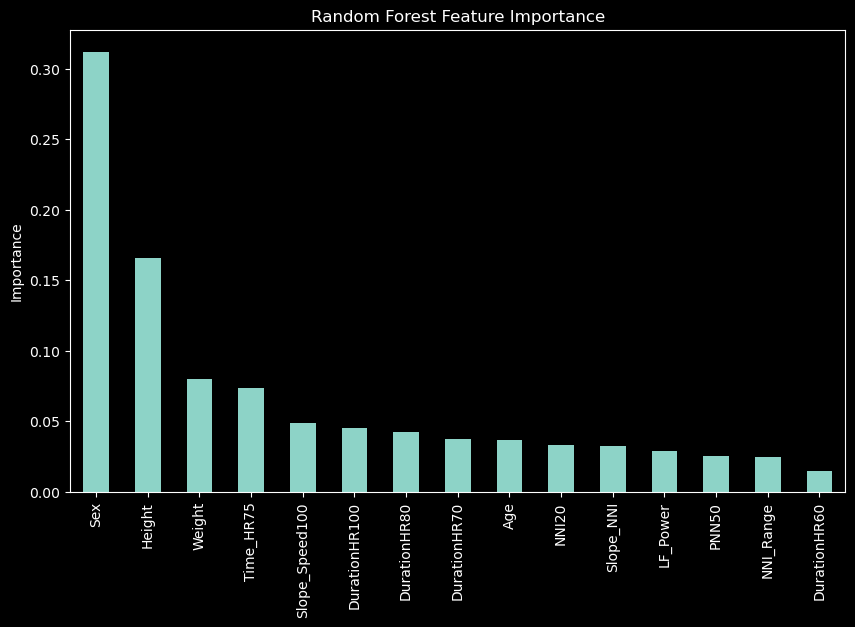

Feature importance scores:
Sex               0.312156
Height            0.165639
Weight            0.079969
Time_HR75         0.073273
Slope_Speed100    0.048482
DurationHR100     0.044888
DurationHR80      0.042072
DurationHR70      0.037510
Age               0.036804
NNI20             0.033105
Slope_NNI         0.032173
LF_Power          0.029176
PNN50             0.025595
NNI_Range         0.024631
DurationHR60      0.014528
dtype: float64


In [32]:
# Random Forest Feature Importance Exercise
feature_importance_exercise = random_forest_feature_importance(final_data_exercise, 'VO2max')
print("Feature importance scores:")
print(feature_importance_exercise)

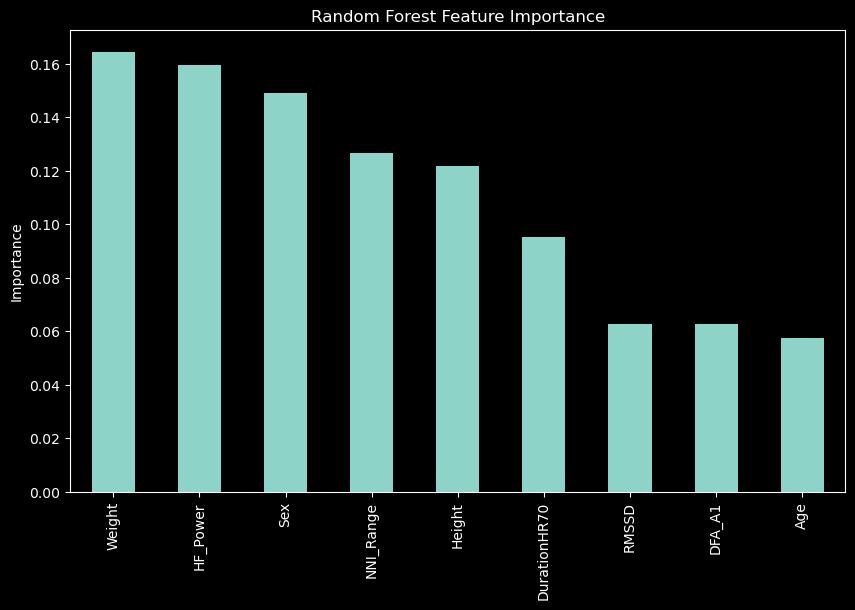

Feature importance scores:
Weight          0.164497
HF_Power        0.159609
Sex             0.148956
NNI_Range       0.126739
Height          0.122016
DurationHR70    0.095214
RMSSD           0.062804
DFA_A1          0.062597
Age             0.057568
dtype: float64


In [33]:
# Random Forest Feature Importance Recovery
feature_importance_recovery = random_forest_feature_importance(final_data_recovery, 'VO2max')
print("Feature importance scores:")
print(feature_importance_recovery)

#### Recursive Feature Elimination (RFE)
RFE is a technique that selects features by recursively removing the least important features based on model performance. RFE removes features one by one, based on their importance, until only a specified number of features remain.

In [34]:
# Recursive Feature Elimination (RFE)

def rfe_feature_selection(data, target_column, model, num_features=13):
    """
    This function performs Recursive Feature Elimination (RFE) to select the top features 
    based on their importance in predicting the target variable. It uses Random Forest Regressor as the model.

    Parameters:
        data (pd.DataFrame): The input dataframe containing features and target.
        target_column (str): The name of the target column.
        num_features (int): The number of top features to select (default is 5).

    Returns:
        list: A list containing the selected feature names.
    """
    # Separate the features and target variable
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Initialize the model (Random Forest Regressor)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Initialize RFE with the RandomForest model and the desired number of features to select
    selector = RFE(rf, n_features_to_select=num_features)
    selector = selector.fit(X, y)
    
    # Get the selected features based on the RFE process
    selected_features = X.columns[selector.support_]
    
    return selected_features

In [35]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Recursive Feature Elimination Exercise
selected_features_exercise_rec = rfe_feature_selection(final_data_exercise, 'VO2max', model, num_features=13)
print(f"Selected Features using RFE (top 13): {selected_features_exercise_rec}")

Selected Features using RFE (top 13): Index(['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'DurationHR70',
       'DurationHR80', 'PNN50', 'Slope_Speed100', 'DurationHR100', 'Age',
       'Slope_NNI', 'LF_Power'],
      dtype='object')


In [36]:
# Recursive Feature Elimination Recovery
selected_features_recovery_rec = rfe_feature_selection(final_data_recovery, 'VO2max', model, num_features=13)
print(f"Selected Features using RFE (top 13): {selected_features_recovery_rec}")

Selected Features using RFE (top 13): Index(['Weight', 'Sex', 'Height', 'HF_Power', 'NNI_Range', 'DFA_A1',
       'DurationHR70', 'RMSSD', 'Age'],
      dtype='object')


#### Greedy-Forward-Backward-Selection
This method performs a greedy selection of features by iteratively adding or removing features based on model performance.

Forward Selection: Starts with an empty feature set and adds the most significant features one by one.

Backward Elimination: Starts with all features and removes the least significant ones.

In [37]:
def greedy_forward_backward_selection2(data, target_column, model = model, num_features=10, direction='forward', scoring='neg_mean_squared_error', cv=5):
    """
    Perform greedy forward or backward feature selection.
    
    Parameters:
        data (pd.DataFrame): The input dataframe containing features and target.
        target_column (str): The name of the target column.
        num_features (int): The number of features to select.
        direction (str): 'forward' for forward selection, 'backward' for backward selection, or 'both' for bidirectional.
        scoring (str): Scoring metric for feature selection.
        cv (int): Number of cross-validation folds.

    Returns:
        list: Selected feature names.
    """
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    # Base model for evaluation
    #base_model = LinearRegression()
    
    # Configure SequentialFeatureSelector
    selector = SequentialFeatureSelector(
        model,
        n_features_to_select=num_features,
        direction=direction,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )
    
    # Fit the selector
    selector.fit(X, y)
    
    # Get selected features
    selected_features = X.columns[selector.get_support()].tolist()
    return selected_features


In [39]:
# greedy forward backward feature selection


def forward_backward_feature_selection(data, target_column, model, n_features, direction='both', scoring='neg_mean_squared_error', cv=5):
    """
    Perform greedy feature selection (forward, backward, or both) to find the optimal feature set.

    Parameters:
        data (pd.DataFrame): The dataset containing features and target.
        target_column (str): The name of the target column.
        model (object): A Scikit-learn compatible ML model for evaluation.
        direction (str): The strategy for feature selection ('forward', 'backward', or 'both').
        scoring (str): Scoring metric for model evaluation during feature selection.
        cv (int): Number of cross-validation folds.

    Returns:
        list: List of the final selected features.
        float: Performance (MSE) of the final model on the test set.
    """
    # Step 1: Separate features and target
    X = data.drop(columns=[target_column])  # Features
    y = data[target_column]  # Target variable

    # Step 2: Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Initialize forward feature selection
    if direction in ['forward', 'both']:
        forward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select=n_features,  # Automatically determines the best number of features
            direction="forward",  # Forward selection
            scoring=scoring,  # Evaluation metric
            cv=cv,  # Cross-validation folds
            n_jobs=-1  # Use all available processors
        )
        forward_selector.fit(X_train, y_train)
        forward_features = X_train.columns[forward_selector.get_support()].tolist()
    else:
        forward_features = X.columns.tolist()  # Skip forward step if not needed

    # Step 4: Update training and testing data to include only forward-selected features
    X_train_forward = X_train[forward_features]
    X_test_forward = X_test[forward_features]
    
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())])

    # Extract model from pipeline
    model = pipeline.named_steps['model']

    # Step 5: Initialize backward feature elimination
    if direction in ['backward', 'both']:
        backward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select=n_features-1,  # Automatically determines the best number of features
            direction="backward",  # Backward elimination
            scoring=scoring,  # Evaluation metric
            cv=cv,  # Cross-validation folds
            n_jobs=-1  # Use all available processors
        )
        backward_selector.fit(X_train_forward, y_train)
        final_features = X_train_forward.columns[backward_selector.get_support()].tolist()
    else:
        final_features = forward_features  # Skip backward step if not needed

    # Step 6: Train the final model using the selected features
    model.fit(X_train[final_features], y_train)
    y_pred = model.predict(X_test[final_features])

    # Step 7: Evaluate model performance
    performance = mean_squared_error(y_test, y_pred)
    print('Performance (MSE):', performance)
    print(y_test)
    #print(y_pred)
    return final_features



# Model Testing

### Forward Backward Features

In [41]:
# Multiple Linear Regression
MLR_model = LinearRegression()

#final_data_exercise = pd.concat([final_data_exercise[selected_features_exercise_rec], final_data_exercise['VO2max']], axis=1)

final_features_MLR = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=MLR_model,
    n_features = 10,
    direction='both',  # Perform both forward and backward selection
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5  # 5-fold cross-validation
)

print("MLR Selected Features:", final_features_MLR)

Performance (MSE): 0.456603118285084
789    1.034166
497    0.400925
139   -1.887132
570    0.235850
66     0.423928
         ...   
450   -1.259303
331    0.154665
886    0.701309
527   -1.984554
482   -0.971097
Name: VO2max, Length: 197, dtype: float64
MLR Selected Features: ['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'DurationHR60', 'DurationHR100', 'Age', 'Slope_NNI']


In [ ]:
s

In [ ]:
# Random Forest Regressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_features_RF = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=RF_model,
    n_features = 15,
    direction='both',  # Perform both forward and backward selection
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=5  # 5-fold cross-validation
)

print("RF Selected Features:", final_features_RF)

KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVR
# # Greedy FS with Support Vector Regression
SVR_model = SVR(kernel='linear')  
final_features = forward_backward_feature_selection(
    data=final_data_exercise,
    target_column='VO2max',
    model=SVR_model,
    n_features=15,
    direction='both',  # Forward and backward
    scoring='neg_mean_squared_error',
    cv=2
)

print("SVR Selected Features:", final_features)

SVR Selected Features: ['Height', 'Sex', 'Weight', 'Time_HR75', 'NNI20', 'DurationHR70', 'NNI_Range', 'DurationHR80', 'PNN50', 'DurationHR100', 'Age', 'Time_SP25', 'Slope_NNI', 'LF_Power']
SVR Performance (MSE): 0.4426176577819092


# Model Fitting

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def model_evaluation_with_grid_search(dataframe, target_column, feature_selection_function, num_features=5, cv=5):
    
    # Modelle zur Vorhersage von VO2max
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'SVR': SVR(),
        'Linear Regression': LinearRegression()
    }
    
    # Pipeline for scaling + model
    def create_pipeline(model):
        return Pipeline([
            ('scaler', StandardScaler()),  # Scaling step
            ('model', model)               # Model step
        ])
    
    # Hyperparameter-Tuning für alle Modelle, die es unterstützen
    param_grids = {
        'Random Forest': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10]
        },
        'XGBoost': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 6, 10]
        },
        'SVR': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        },
        'Linear Regression': {}  # Keine Hyperparameter für Lineare Regression
    }
    
    # Funktion zur Auswertung von Modellen mit Cross-Validation
    def evaluate_model(model, param_grid, X, y, cv=5):
        # Create pipeline
        pipeline = create_pipeline(model)
        
        # GridSearch mit Cross-Validation
        if param_grid:
            grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            print(f"Best Hyperparameters for {model.__class__.__name__}: {best_params}")
            print(f"Best Cross-validation MSE for {model.__class__.__name__}: {-best_score}")
        else:
            # Kein GridSearch für Modelle ohne Hyperparameteroptimierung
            pipeline.fit(X, y)
            best_model = pipeline
            best_params = None
            best_score = None
        
        return best_model, best_params, best_score
    
    # Modelle evaluieren
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
            
        # Feature Selection durchführen
        selected_features = feature_selection_function(dataframe, target_column, model, num_features) #(model musste ergänzt werden für forward_backward_feature_selection function)
        
        # Features und Zielspalte vorbereiten
        X_selected = dataframe[selected_features]
        y_selected = dataframe[target_column]
        
        # Hyperparameter-Tuning durchführen und beste Parameter finden
        best_model, best_params, best_score = evaluate_model(model, param_grids.get(model_name), X_selected, y_selected, cv)
        
        # Endgültige Vorhersage und Evaluierung des besten Modells
        y_pred = best_model.predict(X_selected)
        mse = mean_squared_error(y_selected, y_pred)
        
        print(f"Final MSE for {model_name}: {mse}\n")


In [49]:
# recursive feature selection
model_evaluation_with_grid_search(final_data_exercise, target_column='VO2max', feature_selection_function=rfe_feature_selection, num_features=14)

Evaluating Random Forest...
Best Hyperparameters for RandomForestRegressor: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 50}
Best Cross-validation MSE for RandomForestRegressor: 0.4607787042194541
Final MSE for Random Forest: 0.12524731723279212

Evaluating XGBoost...
Best Hyperparameters for XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best Cross-validation MSE for XGBRegressor: 0.4471781520304624
Final MSE for XGBoost: 0.2171898579960431

Evaluating SVR...
Best Hyperparameters for SVR: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Cross-validation MSE for SVR: 0.44361328061531385
Final MSE for SVR: 0.24430994339073578

Evaluating Linear Regression...
Final MSE for Linear Regression: 0.4230672968788293



In [50]:
# mit greedy_forward_backward_selection2 function
model_evaluation_with_grid_search(final_data_exercise, target_column='VO2max', 
                                  feature_selection_function=greedy_forward_backward_selection2, 
                                  num_features=14, cv=5)

Evaluating Random Forest...
Best Hyperparameters for RandomForestRegressor: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-validation MSE for RandomForestRegressor: 0.4565230520999057
Final MSE for Random Forest: 0.07870588701704648

Evaluating XGBoost...
Best Hyperparameters for XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best Cross-validation MSE for XGBRegressor: 0.45155302449561463
Final MSE for XGBoost: 0.22309550626866723

Evaluating SVR...
Best Hyperparameters for SVR: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Cross-validation MSE for SVR: 0.4428441478182658
Final MSE for SVR: 0.24770966057737878

Evaluating Linear Regression...
Final MSE for Linear Regression: 0.4221907283929431



In [52]:
# mit forward_backward_feature_selection function
model_evaluation_with_grid_search(final_data_exercise, target_column='VO2max',
                                  feature_selection_function=forward_backward_feature_selection, 
                                  num_features=13, cv=5)

Evaluating Random Forest...
Performance (MSE): 0.4508422558650773
789    1.034166
497    0.400925
139   -1.887132
570    0.235850
66     0.423928
         ...   
450   -1.259303
331    0.154665
886    0.701309
527   -1.984554
482   -0.971097
Name: VO2max, Length: 197, dtype: float64
Best Hyperparameters for RandomForestRegressor: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-validation MSE for RandomForestRegressor: 0.46574612428689954
Final MSE for Random Forest: 0.08231418535205416

Evaluating XGBoost...
Performance (MSE): 0.4582287165159755
789    1.034166
497    0.400925
139   -1.887132
570    0.235850
66     0.423928
         ...   
450   -1.259303
331    0.154665
886    0.701309
527   -1.984554
482   -0.971097
Name: VO2max, Length: 197, dtype: float64
Best Hyperparameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50}
Best Cross-validation MSE for XGBRegressor: 0.46356585379546755


In [ ]:
# why same results?
# Features selected by RFE
rfe_selected_features = rfe_feature_selection(final_data_exercise, target_column='VO2max', model = model, num_features=5)

# Features selected by Greedy Forward/Backward Selection
greedy_selected_features = greedy_forward_backward_selection2(final_data_exercise, target_column='VO2max', model = LinearRegression(), num_features=5)

print("RFE Selected Features:", rfe_selected_features)
print("Greedy Selection Features:", greedy_selected_features)

# Check for overlap
print("Are the features the same?", rfe_selected_features == greedy_selected_features)


RFE Selected Features: Index(['Height', 'Sex', 'Weight', 'Time_HR75', 'Slope_Speed100'], dtype='object')
Greedy Selection Features: ['Height', 'Sex', 'Weight', 'Time_HR75', 'Slope_Speed100']
Are the features the same? [ True  True  True  True  True]


## Data Generation with tsfel

In [ ]:
import tsfel

In [ ]:
# prepare dataesets for tsfel use

exercise_data['time'] = pd.to_numeric(exercise_data['time'])
exercise_data['VO2'] = pd.to_numeric(exercise_data['VO2'])
exercise_data['ID_test'] = exercise_data['ID_test'].astype(str)

recovery_data['time'] = pd.to_numeric(recovery_data['time'])
recovery_data['VO2'] = pd.to_numeric(recovery_data['VO2'])
recovery_data['ID_test'] = recovery_data['ID_test'].astype(str)

exercise_data_tsfel = exercise_data.sort_values(by=['ID_test', 'time']).reset_index(drop=True)
recovery_data_tsfel = recovery_data.sort_values(by=['ID_test', 'time']).reset_index(drop=True)

In [ ]:
# Function to segment time series into dynamic time windows
def segment_time_series_dynamic(group, window_size):
    """
    Segments a time series into dynamic time windows based on irregular time intervals.

    Parameters:
        group (DataFrame): A subset of the dataset grouped by ID or another identifier.
        window_size (int): The size of the time window in seconds.

    Returns:
        DataFrame: A DataFrame containing aggregated features and metadata for each time window.
    """
    results = []
    times = group['time'].values  # Extract time values
    vo2_values = group['VO2'].values  # Extract VO2 values

    start_idx = 0
    while start_idx < len(times):
        # Dynamically calculate the end time for the current window
        end_time = times[start_idx] + window_size
        end_idx = np.searchsorted(times, end_time)

        # Extract the data within the current time window
        window_data = group.iloc[start_idx:end_idx]

        # Skip window if it contains too few data points (minimum 3 for slope calculation)
        if len(window_data) < 3:
            start_idx = end_idx
            continue

        # Remove NaN and invalid values
        window_data = window_data.dropna()
        if window_data.empty:
            start_idx = end_idx
            continue

        # Calculate VO2_max for the window
        vo2_max = vo2_values[start_idx:end_idx].max()

        # TSFEL requires time series data as a NumPy array
        ts_data = window_data[['Speed', 'HR', 'VCO2', 'RR', 'VE', 'HR_diff']]

        # Calculate features for each column in the time series
        aggregated_features = {}
        for col in ts_data.columns:
            try:
                cfg_file = tsfel.get_features_by_domain("temporal")  # Temporal features
                tsfel_features = tsfel.time_series_features_extractor(cfg_file, ts_data[col].values, verbose=0)

                # Rename columns to include the metric name
                tsfel_features.columns = [f"{col}_{feature}" for feature in tsfel_features.columns]

                # Add features to the aggregated dictionary
                aggregated_features.update(tsfel_features.iloc[0].to_dict())
            except Exception as e:
                print(f"Error in column {col}: {e}")

        # Add additional metadata
        aggregated_features['ID_test'] = group['ID_test'].iloc[0]
        #aggregated_features['time_start'] = times[start_idx]
        #aggregated_features['time_end'] = times[end_idx - 1] if end_idx < len(times) else times[-1]
        aggregated_features['VO2_max'] = vo2_max

        # Append the results for the current window
        results.append(aggregated_features)

        # Move to the next time window
        start_idx = end_idx

    return pd.DataFrame(results)


In [ ]:
# Aggregate data by ID and time window
window_size = 30  # Time window in seconds
exercise_tsfel_results = pd.concat([
    segment_time_series_dynamic(group, window_size)
    for _, group in exercise_data_tsfel.groupby("ID_test")
])

window_size = 30  # Time window in seconds
recovery_tsfel_results = pd.concat([
    segment_time_series_dynamic(group, window_size)
    for _, group in recovery_data_tsfel.groupby("ID_test")
])

C:\Users\Eva\AppData\Local\Temp\ipykernel_15788\3786209464.py:48: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg_file, ts_data[col].values, verbose=0)
C:\Users\Eva\AppData\Local\Temp\ipykernel_15788\3786209464.py:48: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg_file, ts_data[col].values, verbose=0)
C:\Users\Eva\AppData\Local\Temp\ipykernel_15788\3786209464.py:48: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg_file, ts_data[col].values, verbose=0)
C:\Users\Eva\AppData\Local\Temp\ipykernel_15788\3786209464.py:48: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg_file, ts_data[col].values, verbose=0)
C:\Users\Eva\AppData\Local\Temp\ipykernel_15788\3786

In [ ]:
# merge to subject data

exercise_tsfel = pd.merge(subject_data, exercise_tsfel_results, on='ID_test', how='inner')
recovery_tsfel = pd.merge(subject_data, recovery_tsfel_results, on='ID_test', how='inner')
exercise_tsfel = exercise_tsfel.drop(columns=['ID_test', 'ID'])
recovery_tsfel = recovery_tsfel.drop(columns=['ID_test', 'ID'])

In [ ]:
# normalize data

normalized_exercise_tsfel = normalize_features(exercise_tsfel)
normalized_recovery_tsfel = normalize_features(recovery_tsfel)

In [ ]:
# feature selection for exercise

final_exercise_data_tsfel = feature_selection_pipeline(
    normalized_exercise_tsfel, target_column='VO2_max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1,
    correlation_fs = False, nan_fs = True, mi_fs = True, spearman_fs = True
)

Features to remove with more than 50.0% NaN values: Index([], dtype='object')
Selected Features (MI > 0.0): ['VCO2_0_Area under the curve', 'Speed_0_Area under the curve', 'VE_0_Area under the curve', 'Speed_0_Centroid', 'HR_0_Centroid', 'VCO2_0_Centroid', 'Speed_0_Signal distance', 'HR_0_Area under the curve', 'Height', 'Weight', 'Speed_0_Sum absolute diff', 'Speed_0_Slope', 'Speed_0_Mean absolute diff', 'Speed_0_Mean diff', 'HR_0_Mean diff', 'HR_0_Slope', 'VE_0_Mean absolute diff', 'Sex', 'ID', 'VCO2_0_Sum absolute diff', 'VE_0_Sum absolute diff', 'HR_0_Mean absolute diff', 'RR_0_Area under the curve', 'VCO2_0_Signal distance', 'RR_0_Centroid', 'VE_0_Signal distance', 'RR_0_Median absolute diff', 'HR_0_Sum absolute diff', 'VCO2_0_Mean diff', 'VE_0_Mean diff', 'Speed_0_Median absolute diff', 'VCO2_0_Mean absolute diff', 'VE_0_Slope', 'RR_0_Mean absolute diff', 'Speed_0_Median diff', 'HR_0_Signal distance', 'HR_0_Positive turning points', 'VE_0_Centroid', 'VCO2_0_Slope', 'RR_0_Sum abso

/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_49280/3246266667.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(dataframe[column], dataframe[target_column])


In [ ]:
# feature selection for recovery

final_recovery_data_tsfel = feature_selection_pipeline(
    normalized_recovery_tsfel, target_column='VO2_max', 
    corr_threshold=0.7, 
    nan_threshold=0.5, 
    mi_threshold=0.0, 
    spearman_threshold=0.1,
    correlation_fs = False, nan_fs = True, mi_fs = True, spearman_fs = True
)

Features to remove with more than 50.0% NaN values: Index([], dtype='object')
Selected Features (MI > 0.0): ['VCO2_0_Area under the curve', 'VE_0_Area under the curve', 'HR_0_Area under the curve', 'VCO2_0_Signal distance', 'VCO2_0_Sum absolute diff', 'RR_0_Area under the curve', 'HR_0_Centroid', 'Speed_0_Area under the curve', 'HR_0_Signal distance', 'VE_0_Sum absolute diff', 'VCO2_0_Centroid', 'Speed_0_Centroid', 'Speed_0_Signal distance', 'RR_0_Centroid', 'VE_0_Signal distance', 'VE_0_Centroid', 'HR_0_Sum absolute diff', 'HR_diff_0_Area under the curve', 'HR_diff_0_Signal distance', 'RR_0_Signal distance', 'HR_diff_0_Centroid', 'HR_0_Slope', 'HR_0_Mean diff', 'RR_0_Mean diff', 'VCO2_0_Median diff', 'Weight', 'HR_diff_0_Sum absolute diff', 'VE_0_Mean absolute diff', 'VCO2_0_Mean absolute diff', 'VCO2_0_Slope', 'HR_diff_0_Positive turning points', 'VCO2_0_Median absolute diff', 'RR_0_Sum absolute diff', 'VE_0_Positive turning points', 'HR_0_Median diff', 'VE_0_Mean diff', 'HR_diff_0_S

/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_49280/3246266667.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(dataframe[column], dataframe[target_column])


In [ ]:
final_exercise_data_tsfel

VCO2_0_Area under the curve  Speed_0_Area under the curve  \
0                        -0.597233                      0.163105   
1                        -1.040972                     -0.912736   
2                        -0.491596                      0.060644   
3                        -0.438138                      0.299720   
4                        -0.450278                      0.086260   
...                            ...                           ...   
14157                     0.899681                      0.504642   
14158                     1.293105                     -0.110124   
14159                     0.974383                     -0.110124   
14160                     0.020456                     -0.622430   
14161                    -0.490105                     -0.793198   

       VE_0_Area under the curve  HR_0_Area under the curve    Height  \
0                      -0.492828                   0.288375 -1.599903   
1                      -0.984998                  -0.968975 -1.599903   
2                      -0.404858                   0.124272 -1.599903   
3                      -0.351828                   0.269884 -1.599903   
4                      -0.305183                   0.012174 -1.599903   
...                          ...                        ...       ...   
14157                   0.988294                   1.426692 -0.494764   
14158                   1.327936                   1.479852 -0.494764   
14159                   1.115460                   0.981766 -0.494764   
14160                   0.226361                  -0.170419 -0.494764   
14161                  -0.309794                  -0.564496 -0.494764   

         Weight  Speed_0_Sum absolute diff  Speed_0_Slope  \
0     -2.129149                  -0.311315      -0.043887   
1     -2.129149                   0.195257       1.077889   
2     -2.129149                  -0.311315      -0.043887   
3     -2.129149                   0.195257       0.468925   
4     -2.129149                   0.144599       0.561872   
...         ...                        ...            ...   
14157  0.877393                   3.234687      -2.816275   
14158  0.877393                  -0.311315      -0.043887   
14159  0.877393                  -0.311315      -0.043887   
14160  0.877393                  -0.311315      -0.043887   
14161  0.877393                  -0.311315      -0.043887   

       Speed_0_Mean absolute diff  Speed_0_Mean diff  ...  \
0                       -0.342717          -0.039772  ...   
1                        0.825254           1.085881  ...   
2                       -0.342717          -0.039772  ...   
3                        0.124471           0.410489  ...   
4                        0.182870           0.466772  ...   
...                           ...                ...  ...   
14157                    1.993225          -2.098109  ...   
14158                   -0.342717          -0.039772  ...   
14159                   -0.342717          -0.039772  ...   
14160                   -0.342717          -0.039772  ...   
14161                   -0.342717          -0.039772  ...   

       VCO2_0_Median absolute diff  HR_diff_0_Mean absolute diff  \
0                        -0.564543                     -0.290798   
1                         0.671364                      0.126197   
2                        -0.846758                     -0.474276   
3                        -0.515885                     -0.674433   
4                        -0.788369                     -0.124000   
...                            ...                           ...   
14157                    -1.119241                      0.555106   
14158                    -0.846758                      0.438943   
14159                     0.077740                     -0.436746   
14160                    -0.262865                     -0.073961   
14161                    -0.983000                     -0.249099   

       VCO2_0_Positive turning

### Feature selection and Dimensioanlity Reduction

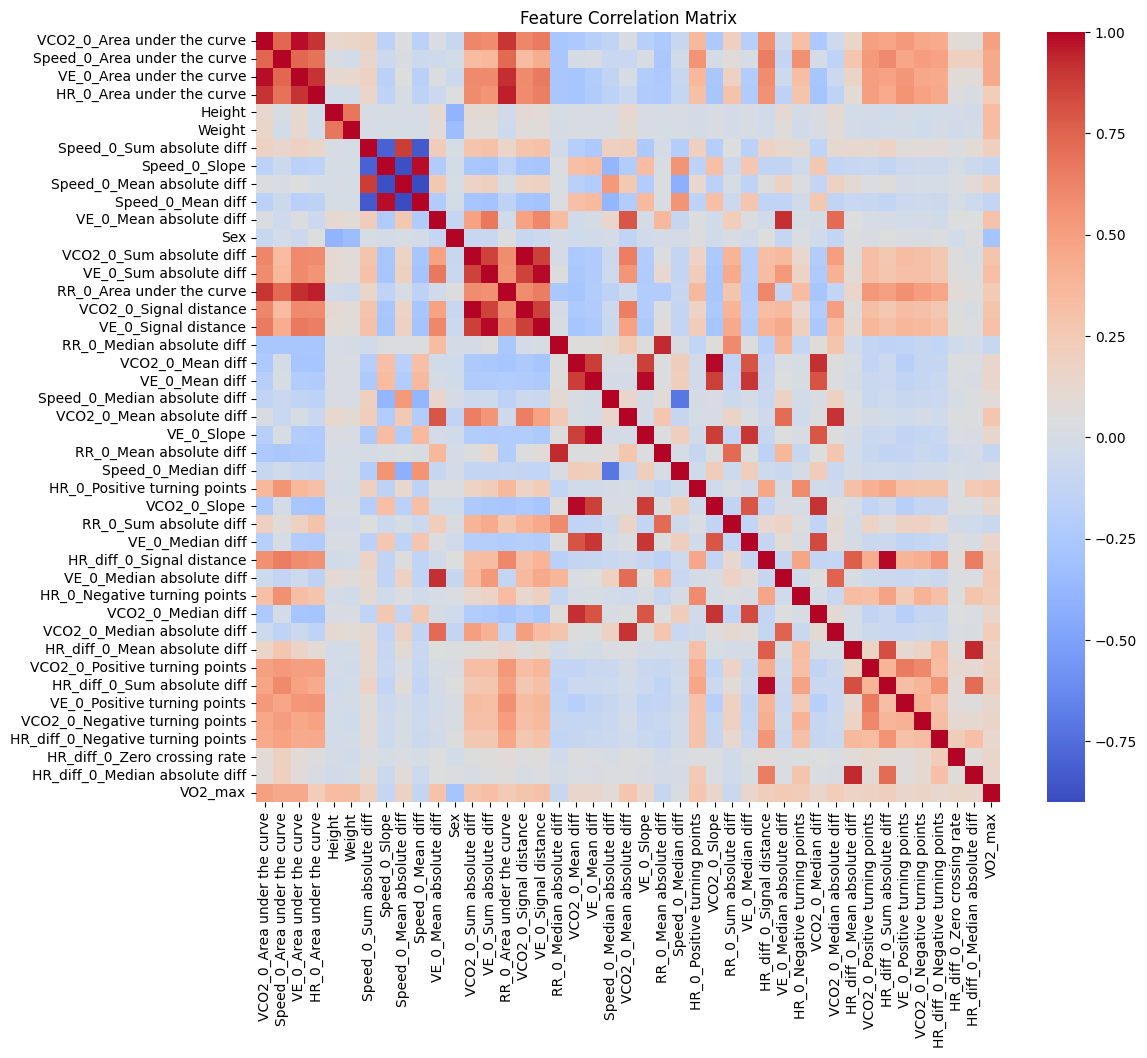

In [ ]:
# Compute the correlation matrix
correlation_matrix = final_exercise_data_tsfel.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

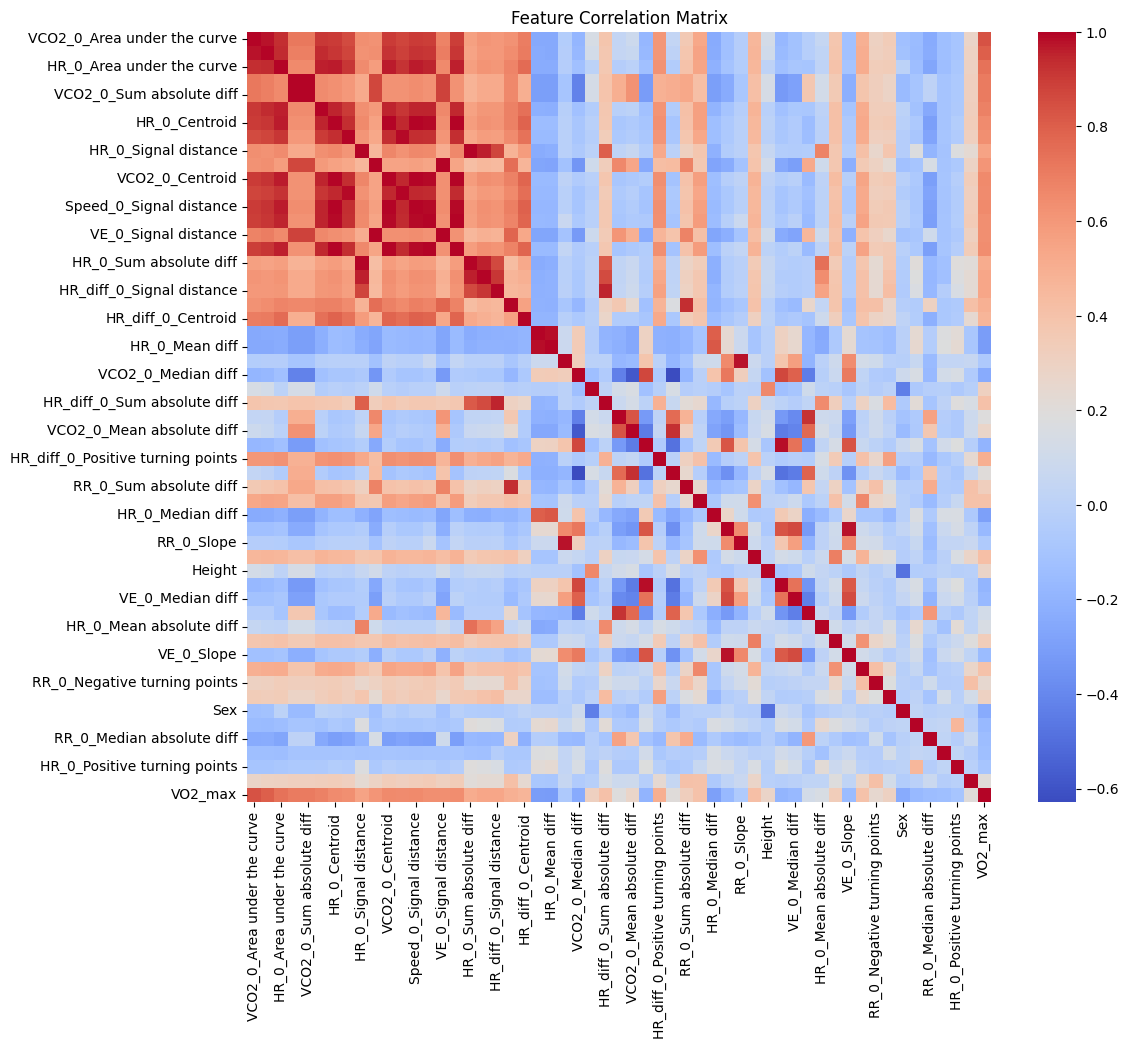

In [ ]:
# Compute the correlation matrix
correlation_matrix_rec = final_recovery_data_tsfel.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_rec, annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# drop highly correlated features

correlation_threshold = 0.9
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
print("Highly correlated features to drop:", high_corr_features)

final_exercise_data_tsfel = final_exercise_data_tsfel.drop(high_corr_features, axis=1)

# for recovery data
upper_triangle_rec = correlation_matrix_rec.where(np.triu(np.ones(correlation_matrix_rec.shape), k=1).astype(bool))
high_corr_features_rec = [column for column in upper_triangle_rec.columns if any(upper_triangle_rec[column] > correlation_threshold)]
print("Highly correlated features to drop:", high_corr_features_rec)

final_recovery_data_tsfel = final_recovery_data_tsfel.drop(high_corr_features_rec, axis=1)

Highly correlated features to drop: ['VE_0_Area under the curve', 'HR_0_Area under the curve', 'Speed_0_Mean diff', 'RR_0_Area under the curve', 'VCO2_0_Signal distance', 'VE_0_Signal distance', 'VE_0_Slope', 'RR_0_Mean absolute diff', 'VCO2_0_Slope', 'VE_0_Median diff', 'VE_0_Median absolute diff', 'VCO2_0_Median diff', 'VCO2_0_Median absolute diff', 'HR_diff_0_Sum absolute diff', 'HR_diff_0_Median absolute diff']
Highly correlated features to drop: ['VE_0_Area under the curve', 'HR_0_Area under the curve', 'VCO2_0_Sum absolute diff', 'RR_0_Area under the curve', 'HR_0_Centroid', 'Speed_0_Area under the curve', 'VCO2_0_Centroid', 'Speed_0_Centroid', 'Speed_0_Signal distance', 'RR_0_Centroid', 'VE_0_Signal distance', 'VE_0_Centroid', 'HR_0_Sum absolute diff', 'HR_diff_0_Area under the curve', 'HR_diff_0_Signal distance', 'HR_0_Mean diff', 'HR_diff_0_Sum absolute diff', 'VCO2_0_Median absolute diff', 'RR_0_Sum absolute diff', 'RR_0_Slope', 'VCO2_0_Mean diff', 'VE_0_Median absolute diff'

In [ ]:
# remove features with low variance
from sklearn.feature_selection import VarianceThreshold

# Define a threshold for variance
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)
reduced_data = selector.fit_transform(final_exercise_data_tsfel)

# Keep only the selected features
selected_features = final_exercise_data_tsfel.columns[selector.get_support()]
final_exercise_data_tsfel = final_exercise_data_tsfel[selected_features]
print("Selected features after variance thresholding:", selected_features)


# for recovery set
reduced_data = selector.fit_transform(final_recovery_data_tsfel)
selected_features_rec = final_recovery_data_tsfel.columns[selector.get_support()]
final_recovery_data_tsfel = final_recovery_data_tsfel[selected_features_rec]
print("Selected features after variance thresholding:", selected_features_rec)


Selected features after variance thresholding: Index(['VCO2_0_Area under the curve', 'Speed_0_Area under the curve', 'Height',
       'Weight', 'Speed_0_Sum absolute diff', 'Speed_0_Slope',
       'Speed_0_Mean absolute diff', 'VE_0_Mean absolute diff', 'Sex',
       'VCO2_0_Sum absolute diff', 'VE_0_Sum absolute diff',
       'RR_0_Median absolute diff', 'VCO2_0_Mean diff', 'VE_0_Mean diff',
       'Speed_0_Median absolute diff', 'VCO2_0_Mean absolute diff',
       'Speed_0_Median diff', 'HR_0_Positive turning points',
       'RR_0_Sum absolute diff', 'HR_diff_0_Signal distance',
       'HR_0_Negative turning points', 'HR_diff_0_Mean absolute diff',
       'VCO2_0_Positive turning points', 'VE_0_Positive turning points',
       'VCO2_0_Negative turning points', 'HR_diff_0_Negative turning points',
       'HR_diff_0_Zero crossing rate', 'VO2_max'],
      dtype='object')
Selected features after variance thresholding: Index(['VCO2_0_Area under the curve', 'VCO2_0_Signal distance',
      

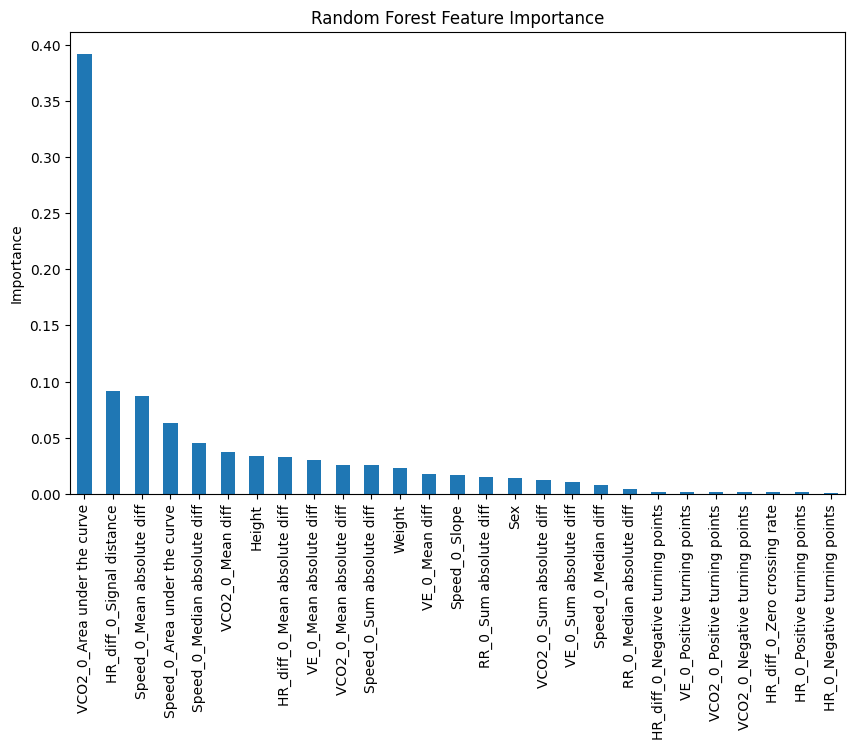

Feature importance scores:
VCO2_0_Area under the curve          0.391861
HR_diff_0_Signal distance            0.091295
Speed_0_Mean absolute diff           0.087108
Speed_0_Area under the curve         0.063569
Speed_0_Median absolute diff         0.045289
VCO2_0_Mean diff                     0.037441
Height                               0.033644
HR_diff_0_Mean absolute diff         0.033286
VE_0_Mean absolute diff              0.030123
VCO2_0_Mean absolute diff            0.026127
Speed_0_Sum absolute diff            0.025697
Weight                               0.023342
VE_0_Mean diff                       0.017784
Speed_0_Slope                        0.017006
RR_0_Sum absolute diff               0.014800
Sex                                  0.014522
VCO2_0_Sum absolute diff             0.012503
VE_0_Sum absolute diff               0.010414
Speed_0_Median diff                  0.008118
RR_0_Median absolute diff            0.004632
HR_diff_0_Negative turning points    0.002118
VE_0_Po

In [ ]:
# Random Forest Feature Importance
feature_importance_exercise_tsfel = random_forest_feature_importance(final_exercise_data_tsfel, 'VO2_max')
print("Feature importance scores:")
print(feature_importance_exercise_tsfel)

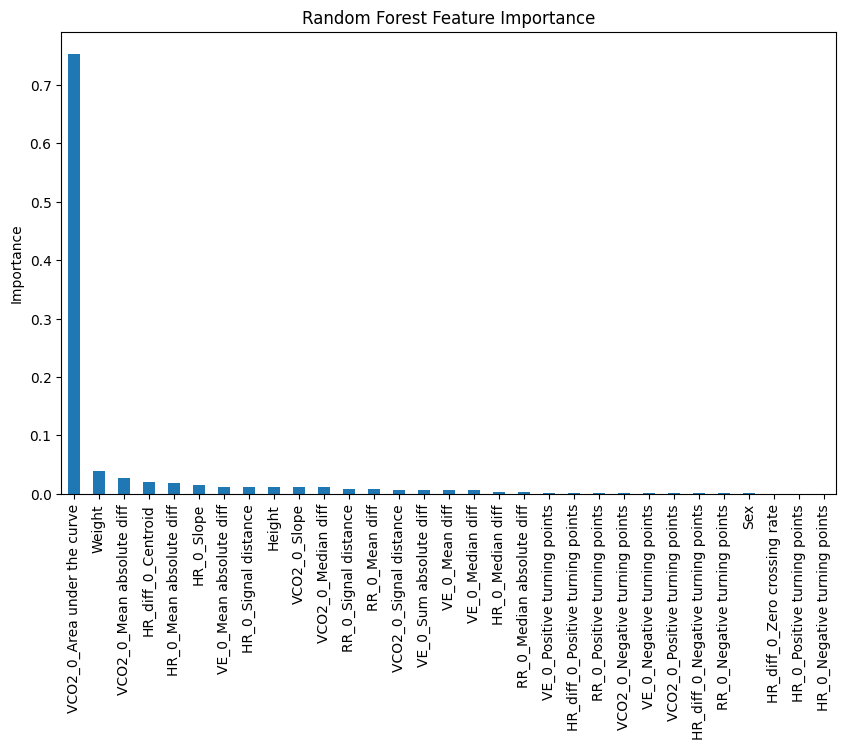

Feature importance scores:
VCO2_0_Area under the curve          0.753163
Weight                               0.038566
VCO2_0_Mean absolute diff            0.027900
HR_diff_0_Centroid                   0.021015
HR_0_Mean absolute diff              0.017914
HR_0_Slope                           0.015274
VE_0_Mean absolute diff              0.012664
HR_0_Signal distance                 0.012558
Height                               0.012289
VCO2_0_Slope                         0.011563
VCO2_0_Median diff                   0.011420
RR_0_Signal distance                 0.009095
RR_0_Mean diff                       0.008639
VCO2_0_Signal distance               0.007279
VE_0_Sum absolute diff               0.007014
VE_0_Mean diff                       0.006661
VE_0_Median diff                     0.006286
HR_0_Median diff                     0.003133
RR_0_Median absolute diff            0.002432
VE_0_Positive turning points         0.002090
HR_diff_0_Positive turning points    0.001749
RR_0_Po

In [ ]:
# Random Forest Feature Importance
feature_importance_recovery_tsfel = random_forest_feature_importance(final_recovery_data_tsfel, 'VO2_max')
print("Feature importance scores:")
print(feature_importance_recovery_tsfel)

In [ ]:
# model fitting
model_evaluation_with_grid_search(final_exercise_data_tsfel, target_column='VO2_max', 
                                  feature_selection_function=greedy_forward_backward_selection2, 
                                  num_features=5, cv=5)

Evaluating Random Forest...
Best Hyperparameters for RandomForestRegressor: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best Cross-validation MSE for RandomForestRegressor: 0.17439010516176534
Final MSE for Random Forest: 0.0226013969832489

Evaluating XGBoost...
Best Hyperparameters for XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
Best Cross-validation MSE for XGBRegressor: 0.14099573265396667
Final MSE for XGBoost: 0.06791299278310468

Evaluating SVR...
Best Hyperparameters for SVR: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best Cross-validation MSE for SVR: 0.132851126761978
Final MSE for SVR: 0.10783883594265127

Evaluating Linear Regression...
Final MSE for Linear Regression: 0.47125917223848696



In [ ]:
# model fitting
model_evaluation_with_grid_search(final_exercise_data_tsfel, target_column='VO2_max', 
                                  feature_selection_function=rfe_feature_selection, 
                                  num_features=5, cv=5)

Evaluating Random Forest...
Best Hyperparameters for RandomForestRegressor: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best Cross-validation MSE for RandomForestRegressor: 0.22252363937263248
Final MSE for Random Forest: 0.0438950308323049

Evaluating XGBoost...
Best Hyperparameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 200}
Best Cross-validation MSE for XGBRegressor: 0.19385102493573367
Final MSE for XGBoost: 0.07184847814912562

Evaluating SVR...
Best Hyperparameters for SVR: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Cross-validation MSE for SVR: 0.29882434738451835
Final MSE for SVR: 0.26773560124620494

Evaluating Linear Regression...
Final MSE for Linear Regression: 0.6153166522750236



In [ ]:
# why same results?
# Features selected by RFE
rfe_selected_features = rfe_feature_selection(final_exercise_data_tsfel, target_column='VO2_max', num_features=5)

# Features selected by Greedy Forward/Backward Selection
greedy_selected_features = greedy_forward_backward_selection2(final_exercise_data_tsfel, target_column='VO2_max', num_features=5)

print("RFE Selected Features:", rfe_selected_features)
print("Greedy Selection Features:", greedy_selected_features)

# Check for overlap
print("Are the features the same?", rfe_selected_features == greedy_selected_features)


KeyboardInterrupt: 